In [21]:
import pandas as pd
from pathlib import Path
import sys
import json
import ast
import numpy as np
# notebook location
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))
print("Added to path:", project_root)

#sys.path.append(r"C:\Users\giusy\OneDrive\Desktop\PAPERS\2026_Sensors_speech\SilentWear")
from utils.I_data_preparation.experimental_config import ORIGINAL_LABELS
from utils.I_data_preparation.read_mat_file import MAT_LABLES
from utils.III_results_analysis.utils import *

Added to path: /home/gspacone/Desktop/SilentWear


# Compare Subject Inter-Session Models

In [22]:
############### CHANGE HERE
models_dire = Path(r"/scratch2/gspacone/sensors_2026_speech_models/models/inter_session")
subjects_to_consider = ["S01", "S02", "S03", "S04"]
conditions_to_consider = ["silent", "vocalized"]

In [23]:

all_rows = []

for subject in subjects_to_consider:
    for condition in conditions_to_consider:
        subject_folder_path = models_dire / subject / condition
        if not subject_folder_path.exists():
            continue

        for model_folder in subject_folder_path.iterdir():
            if not model_folder.is_dir():
                continue

            model_runs = [p for p in model_folder.iterdir() if p.is_dir()]
            print("Model type:", model_folder.name, "contains", len(model_runs), "variants")

            for curr_model_folder in model_runs:
                run_cfg_file = curr_model_folder / "run_cfg.json"
                if not run_cfg_file.exists():
                    continue

                with open(run_cfg_file, "r", encoding="utf-8") as f:
                    run_cfg = json.load(f)

                include_rest = run_cfg["experimental_settings"]["include_rest"]
                original_label_map = ORIGINAL_LABELS.copy() if subject != "S00" else MAT_LABLES.copy()

                # training labels (keep if you need label order)
                train_label_map, train_to_orig, orig_to_train = generate_training_labels(
                    include_rest=include_rest,
                    original_label_map=original_label_map
                )

                cv_path = curr_model_folder / "cv_summary.csv"
                if not cv_path.exists():
                    continue
                model_summary_file = pd.read_csv(cv_path)

                mean_cm, std_cm = mean_std_confusion_matrices(model_summary_file["confusion_matrix"])

                # config signature for "exactly same run cfg" comparison
                sig_full = cfg_signature(run_cfg['model_cfg'], drop_keys=set())                 # truly exact
                if run_cfg.get("seeds") is not None:
                    sig_seeds = cfg_signature(run_cfg["seeds"], drop_keys=set())
                else:
                    sig_seeds = "default"

                #sig_stable = cfg_signature(run_cfg, drop_keys=VOLATILE_KEYS)       # ignore volatile

                row = {
                    "subject": subject,
                    "condition": run_cfg.get("condition", condition),
                    "model_type_folder": model_folder.name,
                    "model_name": run_cfg["model_cfg"]["model"]["name"],
                    "include_rest": include_rest,

                    "balanced_acc_mean": float(model_summary_file["balanced_accuracy"].mean()),
                    "balanced_acc_std": float(model_summary_file["balanced_accuracy"].std()),

                    "mean_cm": None if mean_cm is None else mean_cm.tolist(),
                    "std_cm": None if std_cm is None else std_cm.tolist(),

                    "run_cfg_signature_exact": sig_full,
                    "run_cfg_signature_seeds": sig_seeds,
                    #"run_cfg_signature_stable": sig_stable,

                    "run_path": str(curr_model_folder),
                    "run_cfg": run_cfg,  # keep full config for inspection
                    "train_label_map" : train_label_map,

                    "win_size_ms": run_cfg['experimental_settings']['window_size_ms']
                }

                all_rows.append(row)

summary_df = pd.DataFrame(all_rows)


Model type: random_forest_tmp contains 1 variants
Model type: speechnet_base_tmp contains 1 variants
Model type: tcnformer_base contains 1 variants
Model type: speechnet_base contains 11 variants
Model type: speechnet_base_abl contains 25 variants
Model type: speechnet_base2_abl contains 25 variants
Model type: speechnet_base_hparam_abl contains 54 variants
Model type: random_forest_tmp contains 1 variants
Model type: speechnet_base_tmp contains 1 variants
Model type: speechnet_base contains 11 variants
Model type: tcnformer_base contains 1 variants
Model type: speechnet_base2_abl contains 25 variants
Model type: speechnet_base_abl contains 25 variants
Model type: speechnet_base_hparam_abl contains 54 variants
Model type: random_forest_tmp contains 1 variants
Model type: speechnet_base_tmp contains 1 variants
Model type: speechnet_base contains 10 variants
Model type: tcnformer_base contains 1 variants
Model type: speechnet_base_abl contains 25 variants
Model type: speechnet_base2_abl 

In [24]:
summary_df

,subject,condition,model_type_folder,model_name,include_rest,balanced_acc_mean,balanced_acc_std,mean_cm,std_cm,run_cfg_signature_exact,run_cfg_signature_seeds,run_path,run_cfg,train_label_map,win_size_ms
0,S01,silent,random_forest_tmp,random_forest,False,0.514583,0.033198,"[[0.5433333333333333, 0.14333333333333334, 0.0...","[[0.19362047641943478, 0.1685889148853572, 0.0...",414c1030877f9e380c0105e2aa582b8fc37a162bfb537f...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'silent', 'cv': {'m...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
1,S01,silent,speechnet_base_tmp,speechnet_base,False,0.507083,0.071265,"[[0.45999999999999996, 0.056666666666666664, 0...","[[0.2046134567096374, 0.03681787005729087, 0.1...",de8ef09aa57a2beff4ae3e5cd8e54219f052787d5b494c...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'silent', 'cv': {'m...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
2,S01,silent,tcnformer_base,tcnformer_base,False,0.286667,0.044200,"[[0.39666666666666667, 0.13333333333333333, 0....","[[0.012472191289246462, 0.18153665072253472, 0...",2d707e8a48c4951b9523aebc76562e04121b608630a9a9...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'silent', 'cv': {'m...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
3,S01,silent,speechnet_base,speechnet_base,False,0.518333,0.060497,"[[0.5266666666666667, 0.06, 0.0600000000000000...","[[0.23753362335093153, 0.07071067811865475, 0....",236c437ac50528a61dcf5739eb9f988d1ecf0c751a2b29...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'silent', 'cv': {'m...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
4,S01,silent,speechnet_base,speechnet_base,False,0.518333,0.060497,"[[0.5266666666666667, 0.06, 0.0600000000000000...","[[0.23753362335093153, 0.07071067811865475, 0....",236c437ac50528a61dcf5739eb9f988d1ecf0c751a2b29...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'silent', 'cv': {'m...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,S04,vocalized,speechnet_base_hparam_abl,speechnet_base_hparam_abl,False,0.779583,0.073126,"[[0.88, 0.02, 0.02, 0.06333333333333334, 0.003...","[[0.10801234497346433, 0.016329931618554522, 0...",5e4d8e5b85610060e906a73ed34051628bc34177cfbd40...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'vocalized', 'cv': ...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
720,S04,vocalized,speechnet_base_hparam_abl,speechnet_base_hparam_abl,False,0.758750,0.135848,"[[0.7266666666666667, 0.02333333333333333, 0.0...","[[0.2322833518691246, 0.026246692913372706, 0....",d32ab14b32839872b9a7125f963faa42a9087e68403cff...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'vocalized', 'cv': ...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
721,S04,vocalized,speechnet_base_hparam_abl,speechnet_base_hparam_abl,False,0.819167,0.065435,"[[0.8866666666666667, 0.0033333333333333335, 0...","[[0.06342099196813479, 0.004714045207910317, 0...",19b7bf31a5240aeb4b6841077f5f554c37eedab8b7d7cb...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'vocalized', 'cv': ...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
722,S04,vocalized,speechnet_base_hparam_abl,speechnet_base_hparam_abl,False,0.791667,0.104630,"[[0.7566666666666667, 0.013333333333333334, 0....","[[0.1508494466531301, 0.012472191289246471, 0....",2e33bc74fbca754a71cf41706312a84bc974ca28ff4a00...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'vocalized', 'cv': ...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400


RANDOM FOREST | WIN_1400S


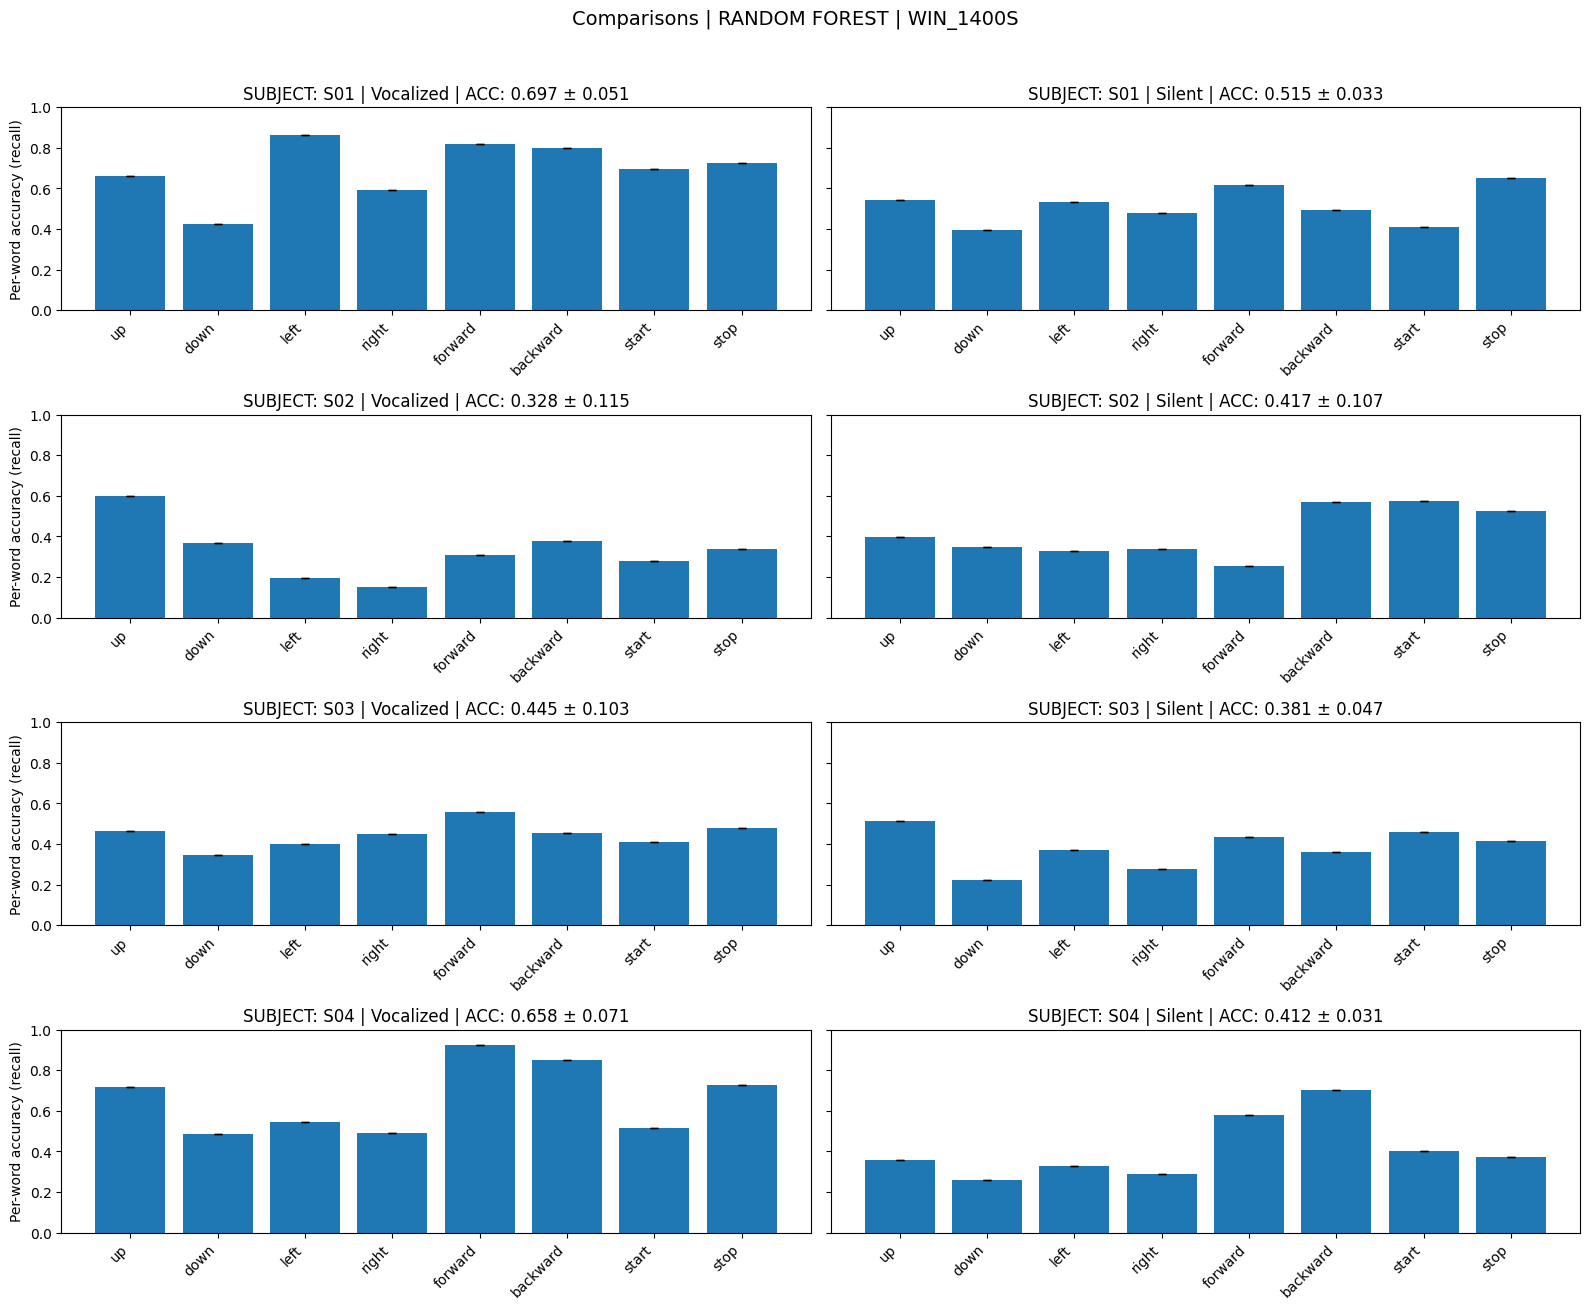

In [25]:
model_to_select = 'random_forest'

model_df = summary_df[summary_df['model_name'] == model_to_select]
model_win = model_df[model_df['win_size_ms']==1400]
plot_subject_word_accuracy_grid_from_summary(model_win, "vocalized", "silent", title_extras="RANDOM FOREST | WIN_1400S")

In [26]:
silent_accs = model_win[model_win['condition'] == 'silent']['balanced_acc_mean'].values
print(f"Silent ACC | avg across subjects: {np.mean(silent_accs):.2f} ± {np.std(silent_accs):.2f}")
vocalized_accs = model_win[model_win['condition'] == 'vocalized']['balanced_acc_mean'].values
print(f"Vocalized ACC | avg across subjects: {np.mean(vocalized_accs):.2f} ± {np.std(vocalized_accs):.2f}")

Silent ACC | avg across subjects: 0.43 ± 0.05
Vocalized ACC | avg across subjects: 0.53 ± 0.15


In [27]:
model_to_select = 'speechnet_base'

model_df = summary_df[summary_df['model_name'] == model_to_select]


In [28]:
model_df['run_cfg'].iloc[-1]

{'base_cfg': {'condition': 'vocalized',
  'cv': {'mode': 'leave_one_batch_out', 'n_splits': 5, 'val_size': 0.2},
  'data': {'data_directory': '/baltic/users/ml_datasets/iis_bio_internal_datasets/2026_spacone_speech_classification_hmi',
   'models_main_directory': '/scratch2/gspacone/sensors_2026_speech_models',
   'subject_id': 'S04'},
  'experiment': {'include_rest': False, 'seed': 42, 'type': 'global'},
  'paths': {'models': 'models',
   'processed': 'processed',
   'raw': 'raw',
   'win_and_feats': 'wins_and_feats'},
  'window': {'window_size_s': 1.4}},
 'condition': 'vocalized',
 'experiment_type': 'inter-session',
 'experimental_settings': {'include_rest': False, 'window_size_ms': 1400},
 'model_cfg': {'model': {'kind': 'dl',
   'kwargs': {'blocks_config': [{'kernel': [1, 4],
      'out_channels': 8,
      'pool': [1, 8]},
     {'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]},
     {'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]},
     {'kernel': [7, 1], 'out_channels

SPEECH NET BASE | WIN_1400S - variant:0


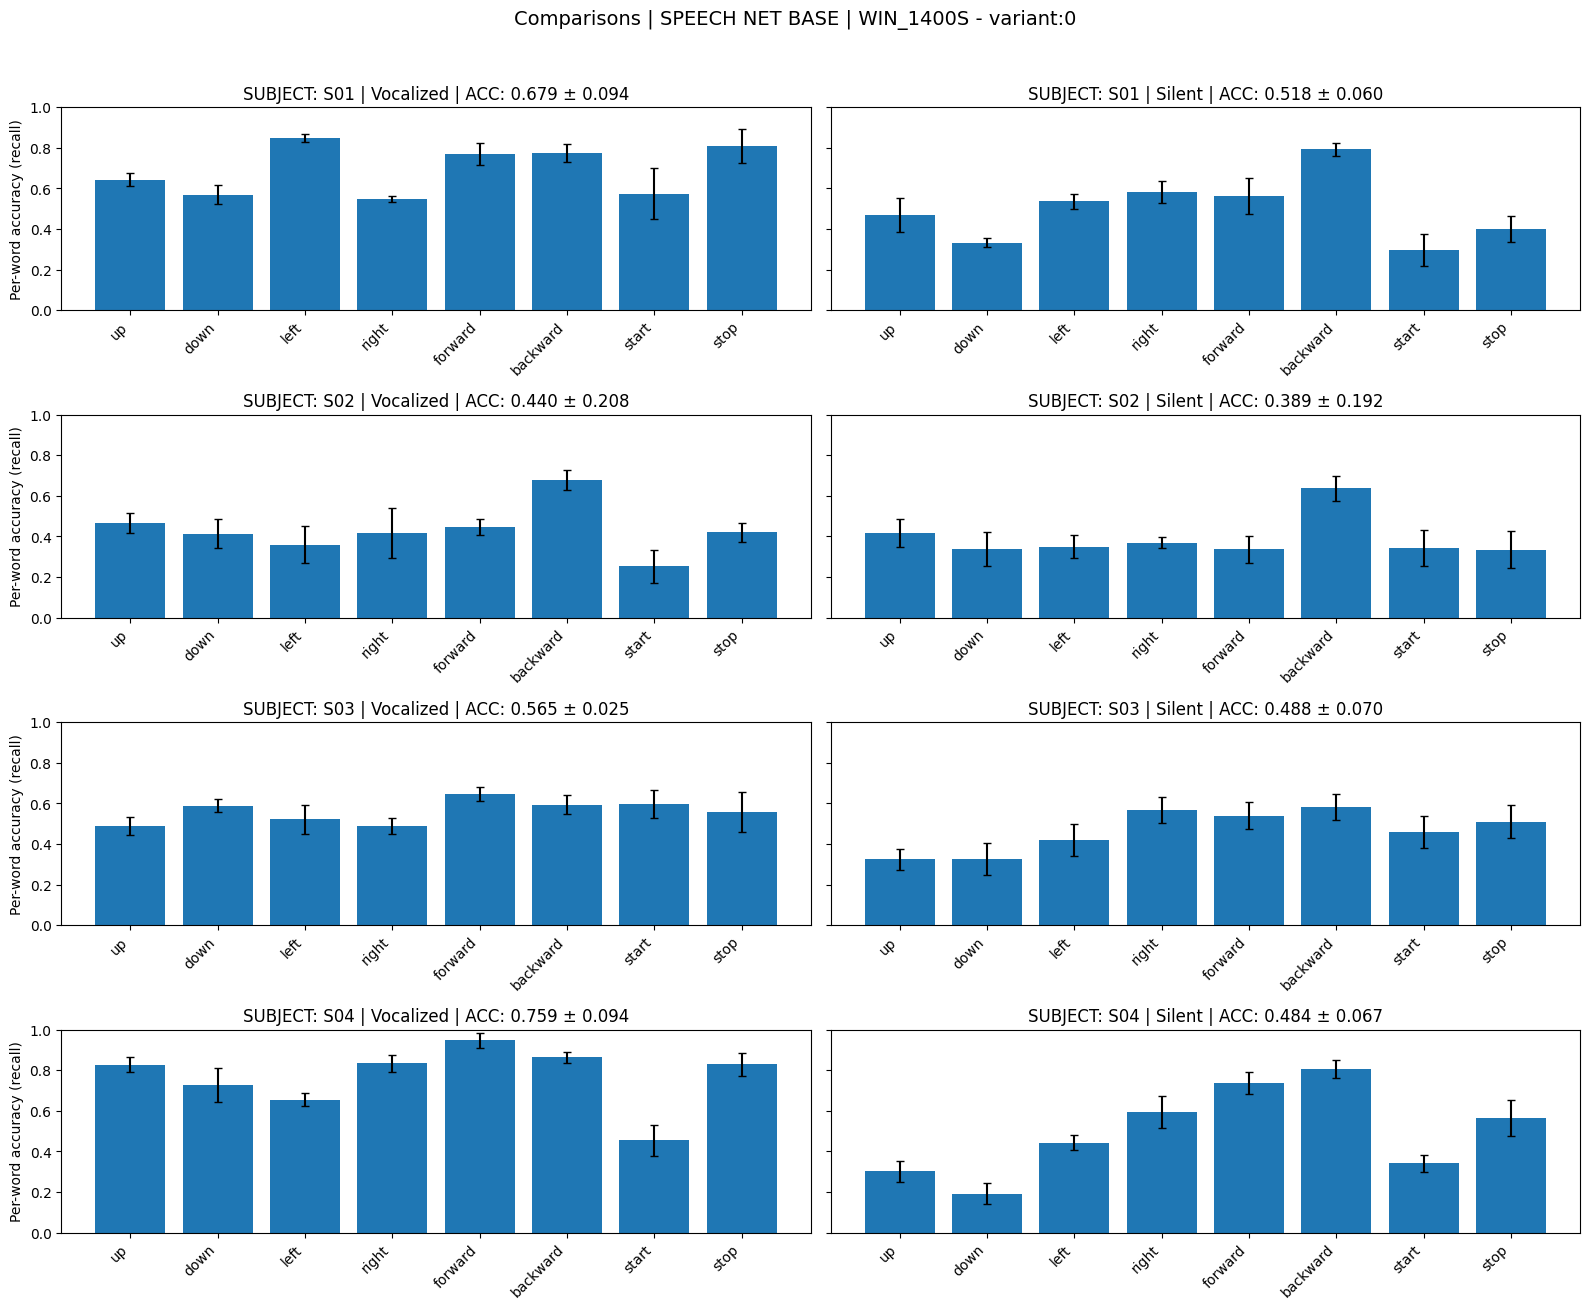

Silent ACC | avg across subjects: 0.46 ± 0.05
Vocalized ACC | avg across subjects: 0.61 ± 0.13
{'model': {'kind': 'dl', 'kwargs': {'blocks_config': [{'kernel': [1, 4], 'out_channels': 8, 'pool': [1, 8]}, {'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]}, {'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]}, {'kernel': ['full', 1], 'out_channels': 32, 'pool': [1, 1]}, {'kernel': [1, 1], 'out_channels': 32, 'pool': [1, 1]}], 'global_pool': 'avg', 'p_dropout': 0.5, 'train_cfg': {'lr': '1e-3', 'num_epochs': 50, 'optimizer_cfg': {'lr': '1e-3', 'name': 'adam'}, 'weight_decay': '1e-4'}}, 'name': 'speechnet_base'}}
SPEECH NET BASE | WIN_1400S - variant:1


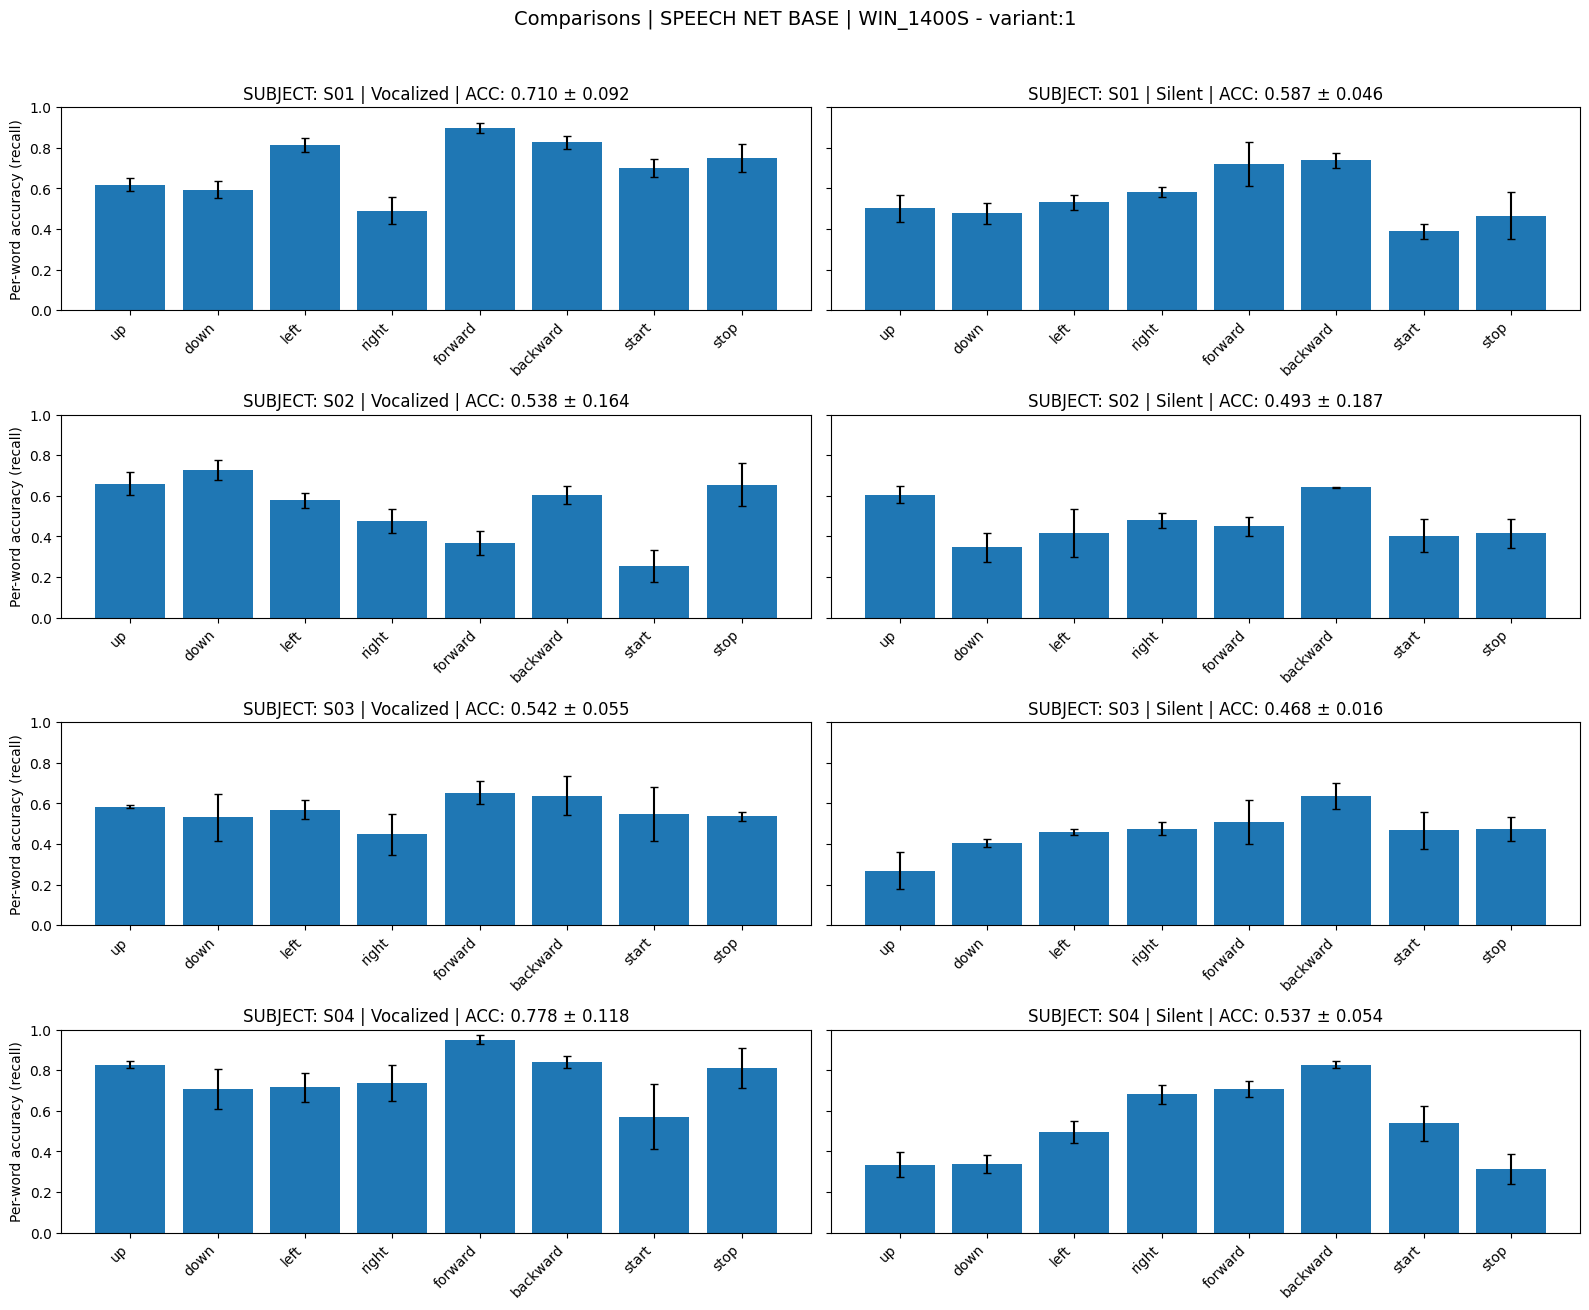

Silent ACC | avg across subjects: 0.50 ± 0.04
Vocalized ACC | avg across subjects: 0.65 ± 0.10
{'model': {'kind': 'dl', 'kwargs': {'blocks_config': [{'kernel': [1, 4], 'out_channels': 8, 'pool': [1, 8]}, {'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]}, {'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]}, {'kernel': [7, 1], 'out_channels': 32, 'pool': [1, 1]}, {'kernel': [7, 1], 'out_channels': 32, 'pool': [1, 1]}], 'global_pool': 'avg', 'p_dropout': 0.5, 'train_cfg': {'lr': '1e-3', 'num_epochs': 50, 'optimizer_cfg': {'lr': '1e-3', 'name': 'adam'}, 'weight_decay': '1e-4'}}, 'name': 'speechnet_base'}}
SPEECH NET BASE | WIN_1400S - variant:2


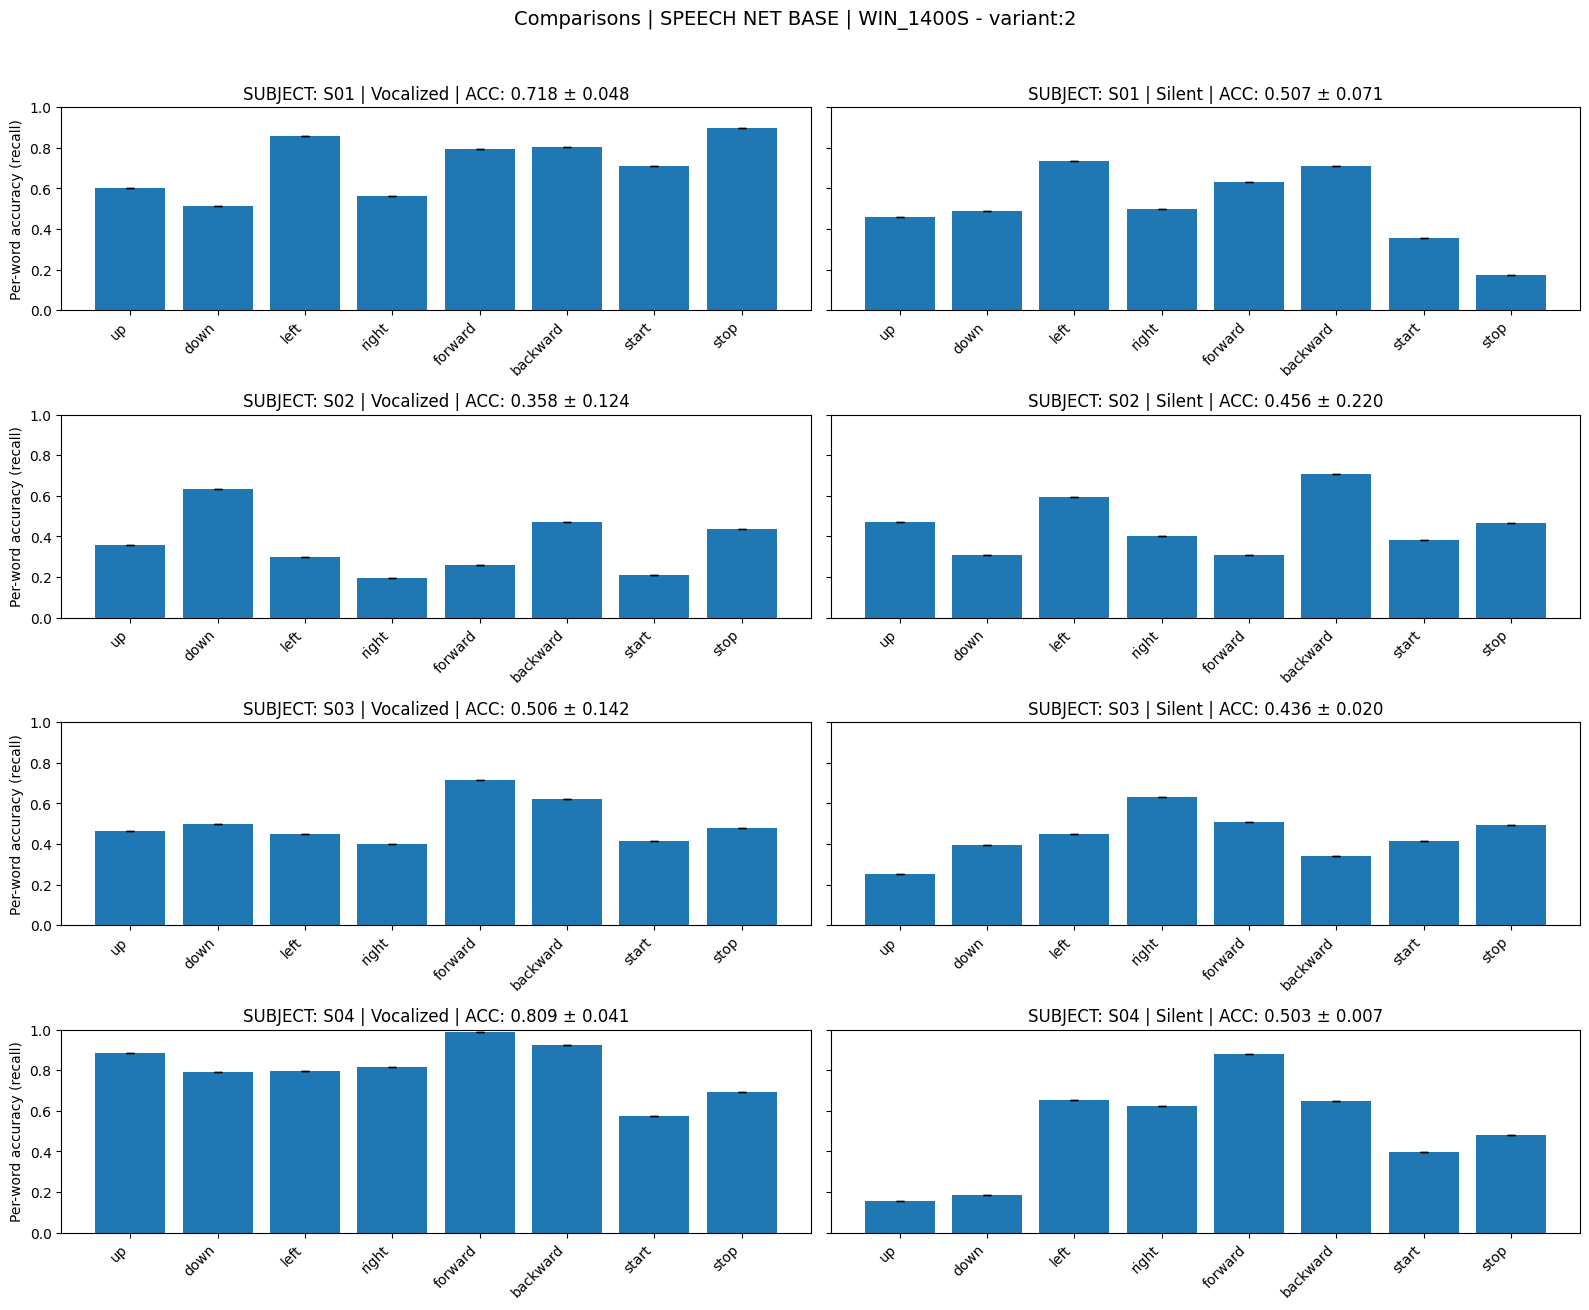

Silent ACC | avg across subjects: 0.48 ± 0.03
Vocalized ACC | avg across subjects: 0.60 ± 0.18
{'model': {'kind': 'dl', 'kwargs': {'blocks_config': [{'kernel': [1, 4], 'out_channels': 4, 'pool': [1, 8]}, {'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]}, {'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]}, {'kernel': ['full', 1], 'out_channels': 16, 'pool': [1, 1]}, {'kernel': [1, 1], 'out_channels': 16, 'pool': [1, 1]}], 'global_pool': 'avg', 'p_dropout': 0.5, 'train_cfg': {'lr': '1e-3', 'num_epochs': 50, 'optimizer_cfg': {'lr': '1e-3', 'name': 'adam'}, 'weight_decay': '1e-4'}}, 'name': 'speechnet_base'}}


In [29]:
model_df = summary_df[summary_df["model_name"] == model_to_select]

dfs_shared = {
    sig: group
    for sig, group in model_df.groupby("run_cfg_signature_exact")
    if len(group) > 1
}

for key_id in range(len(dfs_shared.keys())):
    curr_key = list(dfs_shared.keys())[key_id]
    curr_df = dfs_shared[curr_key]
    model_win = curr_df[curr_df['win_size_ms']==1400]
    plot_subject_word_accuracy_grid_from_summary(model_win, "vocalized", "silent", title_extras=f"SPEECH NET BASE | WIN_1400S - variant:{key_id}")

    silent_accs = model_win[model_win['condition'] == 'silent']['balanced_acc_mean'].values
    print(f"Silent ACC | avg across subjects: {np.mean(silent_accs):.2f} ± {np.std(silent_accs):.2f}")
    vocalized_accs = model_win[model_win['condition'] == 'vocalized']['balanced_acc_mean'].values
    print(f"Vocalized ACC | avg across subjects: {np.mean(vocalized_accs):.2f} ± {np.std(vocalized_accs):.2f}")

    print(model_win["run_cfg"].iloc[0]["model_cfg"])


In [30]:
model_df = summary_df[summary_df["model_name"] == model_to_select]

# Models sharing the same architecture
dfs_shared = {
    sig: group
    for sig, group in model_df.groupby("run_cfg_signature_exact")
    if len(group) > 1
}

for key_id in range(len(dfs_shared.keys())):
    curr_key = list(dfs_shared.keys())[key_id]
    curr_df = dfs_shared[curr_key]


    # check if we need to further split by seeds
    seed_sigs = list(curr_df["run_cfg_signature_seeds"].unique())
    
    for sig_seed_id in range(len(seed_sigs)):

        model_seed_df = curr_df[curr_df["run_cfg_signature_seeds"] == seed_sigs[sig_seed_id]]

        print(f"Model variant {key_id} | seed variant {sig_seed_id} | seed sig: {seed_sigs[sig_seed_id]}")
        print("Seeds set to:", model_seed_df["run_cfg"].iloc[0].get("seeds", "default"))
        model_win = model_seed_df[model_seed_df['win_size_ms']==1400]


        silent_accs = model_win[model_win['condition'] == 'silent']['balanced_acc_mean'].values
        print(f"Silent ACC | avg across subjects: {np.mean(silent_accs):.2f} ± {np.std(silent_accs):.2f}")
        vocalized_accs = model_win[model_win['condition'] == 'vocalized']['balanced_acc_mean'].values
        print(f"Vocalized ACC | avg across subjects: {np.mean(vocalized_accs):.2f} ± {np.std(vocalized_accs):.2f}")


        blocks_config = model_win["run_cfg"].iloc[0]["model_cfg"]["model"]["kwargs"]['blocks_config']
        for curr_block in blocks_config:
            print(curr_block)
        print("\n\n")

Model variant 0 | seed variant 0 | seed sig: default
Seeds set to: default
Silent ACC | avg across subjects: 0.47 ± 0.05
Vocalized ACC | avg across subjects: 0.60 ± 0.13
{'kernel': [1, 4], 'out_channels': 8, 'pool': [1, 8]}
{'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]}
{'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]}
{'kernel': ['full', 1], 'out_channels': 32, 'pool': [1, 1]}
{'kernel': [1, 1], 'out_channels': 32, 'pool': [1, 1]}



Model variant 0 | seed variant 1 | seed sig: cd7a39fc349b06c0ed99e3a32f30e0e43d8e25601f07bcf3045884db0a775285
Seeds set to: {'random_seed': 0, 'rgn_seed': 42, 'torch_manual_seed': 42}
Silent ACC | avg across subjects: 0.45 ± 0.04
Vocalized ACC | avg across subjects: 0.60 ± 0.15
{'kernel': [1, 4], 'out_channels': 8, 'pool': [1, 8]}
{'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]}
{'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]}
{'kernel': ['full', 1], 'out_channels': 32, 'pool': [1, 1]}
{'kernel': [1, 1], 'out_channels': 32, 'poo

In [53]:
run_cfgs = curr_df["run_cfg"]

run_cfg_dict = curr_df["run_cfg"].iloc[0]
run_cfg_dict.keys()

dict_keys(['base_cfg', 'condition', 'experiment_type', 'experimental_settings', 'model_cfg', 'subject'])

In [81]:
run_cfg_dict

{'base_cfg': {'condition': 'silent',
  'cv': {'mode': 'leave_one_batch_out', 'n_splits': 5, 'val_size': 0.2},
  'data': {'data_directory': '/baltic/users/ml_datasets/iis_bio_internal_datasets/2026_spacone_speech_classification_hmi',
   'models_main_directory': '/scratch2/gspacone/sensors_2026_speech_models',
   'subject_id': 'S01'},
  'experiment': {'include_rest': False, 'seed': 42, 'type': 'global'},
  'paths': {'models': 'models',
   'processed': 'processed',
   'raw': 'raw',
   'win_and_feats': 'wins_and_feats'},
  'window': {'window_size_s': 1.4}},
 'condition': 'silent',
 'experiment_type': 'inter-session',
 'experimental_settings': {'include_rest': False, 'window_size_ms': 1400},
 'model_cfg': {'model': {'kind': 'dl',
   'kwargs': {'blocks_config': [{'kernel': [1, 4],
      'out_channels': 4,
      'pool': [1, 8]},
     {'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]},
     {'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]},
     {'kernel': ['full', 1], 'out_channels'

In [ ]:
import copy



canon = curr_df["run_cfg"].apply(normalize_and_canonicalize)

In [82]:
run_cfg_file_path = "/scratch2/gspacone/sensors_2026_speech_models/models/inter_session/S02/silent/speechnet_base/model_11/run_cfg.json"

with open(run_cfg_file_path, "r", encoding="utf-8") as f:
    run_cfg = json.load(f)

In [87]:
run_cfg.keys()

dict_keys(['base_cfg', 'condition', 'experiment_type', 'experimental_settings', 'model_cfg', 'seeds', 'subject'])

In [101]:
run_cfg['model_cfg']

{'model': {'kind': 'dl',
  'kwargs': {'blocks_config': [{'kernel': [1, 4],
     'out_channels': 8,
     'pool': [1, 8]},
    {'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]},
    {'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]},
    {'kernel': [7, 1], 'out_channels': 32, 'pool': [1, 1]},
    {'kernel': [7, 1], 'out_channels': 32, 'pool': [1, 1]}],
   'global_pool': 'avg',
   'p_dropout': 0.5,
   'train_cfg': {'lr': '1e-3',
    'num_epochs': 50,
    'optimizer_cfg': {'lr': '1e-3', 'name': 'adam'},
    'scheduler': {'factor': 0.1,
     'mode': 'min',
     'name': 'ReduceLROnPlateau',
     'patience': 1},
    'weight_decay': '1e-4'}},
  'name': 'speechnet_base'}}

In [112]:
condition = run_cfg["base_cfg"]["condition"]
subject = run_cfg["base_cfg"]["data"]["subject_id"]
rest_included = run_cfg["experimental_settings"]["include_rest"]
window_size_ms = int(run_cfg["experimental_settings"]["window_size_ms"])
model_name = run_cfg["model_cfg"]["model"]["name"]
model_architecture_settings = run_cfg["model_cfg"]["model"]["kwargs"].get("blocks_config", None)            # this is needed to sort same architecture, with different variants
# might also want to include pooling type or other settings
# pooling_type = run_cfg["model_cfg"]["model"]["kwargs"].get("global_pool", None)
# p_dropout = run_cfg["model_cfg"]["model"]["kwargs"].get("p_dropout", None) 

# Given the same model architecture, we want to isolate different training settings.
# In particular, group by combinations of: learning rate
lr = run_cfg["model_cfg"]["model"]["kwargs"]["train_cfg"].get("lr", None)
print(lr)

1e-3


In [111]:
run_cfg["model_cfg"]["model"]["kwargs"]

{'blocks_config': [{'kernel': [1, 4], 'out_channels': 8, 'pool': [1, 8]},
  {'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]},
  {'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]},
  {'kernel': [7, 1], 'out_channels': 32, 'pool': [1, 1]},
  {'kernel': [7, 1], 'out_channels': 32, 'pool': [1, 1]}],
 'global_pool': 'avg',
 'p_dropout': 0.5,
 'train_cfg': {'lr': '1e-3',
  'num_epochs': 50,
  'optimizer_cfg': {'lr': '1e-3', 'name': 'adam'},
  'scheduler': {'factor': 0.1,
   'mode': 'min',
   'name': 'ReduceLROnPlateau',
   'patience': 1},
  'weight_decay': '1e-4'}}

In [ ]:
def load_all_results_upd(models_dire, subjects_to_consider = ["S01", "S02", "S03", "S04"], conditions_to_consider = ["silent","vocalized"]):
    """
    Loads all results from the directory where models where saved for the given subjects and conditions.
    
    :param models_dire: Path to the directory containing model results
    :param subjects_to_consider: List of subject identifiers to include
    :param conditions_to_consider: List of condition names to include 
    :type conditions_to_consider: list of str
    :return: DataFrame summarizing all model results
    :rtype: pd.DataFrame
    """
    
    all_rows = []

    for subject in subjects_to_consider:
        for condition in conditions_to_consider:
            subject_folder_path = models_dire / subject / condition
            if not subject_folder_path.exists():
                continue

            for model_folder in subject_folder_path.iterdir():
                if not model_folder.is_dir():
                    continue

                model_runs = [p for p in model_folder.iterdir() if p.is_dir()]
                # If the same model was trained multiple times (e.g., different seeds), we have multiple runs
                #print("Model type:", model_folder.name, "contains", len(model_runs), "variants")

                for curr_model_folder in model_runs:
                    # Read the config
                    run_cfg_file = curr_model_folder / "run_cfg.json"
                    if not run_cfg_file.exists():
                        continue

                    with open(run_cfg_file, "r", encoding="utf-8") as f:
                        run_cfg = json.load(f)

                    include_rest = run_cfg["experimental_settings"]["include_rest"]
                    # This is to map training labels back to original labels (if rest was removed during training)
                    original_label_map = ORIGINAL_LABELS.copy() 

                    # training labels (keep if you need label order)
                    train_label_map, train_to_orig, orig_to_train = generate_training_labels(
                        include_rest=include_rest,
                        original_label_map=original_label_map
                    )

                    cv_path = curr_model_folder / "cv_summary.csv"
                    if not cv_path.exists():
                        continue
                    model_summary_file = pd.read_csv(cv_path)

                    mean_cm, std_cm = mean_std_confusion_matrices(model_summary_file["confusion_matrix"])
                    # config signature for "exactly same run cfg" comparison
                    sig_full = cfg_signature(run_cfg['model_cfg'], drop_keys=set())                 # truly exact
                    # If models where trained with differnt seeds, we need to keep track 
                    if run_cfg.get("seeds") is not None:
                        sig_seeds = cfg_signature(run_cfg["seeds"], drop_keys=set())
                    else:
                        sig_seeds = "default"

                    #sig_stable = cfg_signature(run_cfg, drop_keys=VOLATILE_KEYS)       # ignore volatile

                    row = {
                        "subject": subject,
                        "condition": run_cfg.get("condition", condition),
                        "model_type_folder": model_folder.name,
                        "model_name": run_cfg["model_cfg"]["model"]["name"],
                        "include_rest": include_rest,

                        "balanced_acc_mean": float(model_summary_file["balanced_accuracy"].mean()),
                        "balanced_acc_std": float(model_summary_file["balanced_accuracy"].std()),

                        "mean_cm": None if mean_cm is None else mean_cm.tolist(),
                        "std_cm": None if std_cm is None else std_cm.tolist(),

                        "run_cfg_signature_exact": sig_full,
                        "run_cfg_signature_seeds": sig_seeds,
                        "run_path": str(curr_model_folder),
                        "run_cfg": run_cfg,  # keep full config for inspection
                        "train_label_map" : train_label_map,

                        "win_size_ms": run_cfg['experimental_settings']['window_size_ms']
                    }

                    all_rows.append(row)

    summary_df = pd.DataFrame(all_rows)

In [134]:
df_summary = pd.read_csv("/scratch2/gspacone/sensors_2026_speech_models/models/inter_session/S02/silent/speechnet_base/model_2/cv_summary.csv")
df_needed = df_summary[["fold_num", "test_session"]]
model_parent_dire = Path("/scratch2/gspacone/sensors_2026_speech_models/models/inter_session/S02/silent/speechnet_base/model_2")
model_names = []
test_session = []
for idx, row in df_needed.iterrows():
    fold_num = row["fold_num"]
    test_sess = row["test_session"]
    model_names.append(model_parent_dire/f"leave_one_session_out_fold_{fold_num}.pt")
    test_session.append(test_sess)

models_to_ft = {
    "model_paths": model_names,                     # Path to the specified Model
    "test_sessions": test_session                   # Fine-Tuning Session
}